In [83]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import math
import seaborn as sns 
from PIL import Image
randomstate = 42
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit import RDConfig
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False
size = (150, 150)
import plotly.express as px
import mols2grid
from IPython.display import SVG

def view_difference(mol1, mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    for atom in mol1.GetAtoms():
        if atom.GetIdx() not in match1:
            target_atm1.append(atom.GetIdx())
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm2 = []
    for atom in mol2.GetAtoms():
        if atom.GetIdx() not in match2:
            target_atm2.append(atom.GetIdx())
    return Draw.MolsToGridImage([mol1, mol2],highlightAtomLists=[target_atm1, target_atm2],subImgSize=(400,400),useSVG=True)

# Introduction

Generate analogs using "medicinal chemistry" intuition which is obtained via mmpa of the ChEMBL database

Workflow described in J. Chem. Inf. Model. 2021, 61, 2, 729 (https://pubs.acs.org/doi/10.1021/acs.jcim.0c01143 and overview code https://github.com/mahendra-awale/medchem_moves). The code is included in the mmpdb v2.2 package which must be directly installed from github (pip install git+https://github.com/mahendra-awale/medchem_moves.git). A similar workflow is described in the documentation for mmpdb v3 (https://github.com/adalke/mmpdb/tree/v3-dev#4-identify-possible-transforms). This package requires the chemblDB3.sqlitdb to be downloaded and stored.

Some examples to test the workflow (make cuts and save smiles in chemdraw):

O=S(=O)(c3ccc(n1nc(cc1c2ccc(cc2)C)C(F)(F)F)cc3)N with *S(=O)(=O)(N) (example from the GH)

C[C@@H]1CN(C2=NC(=CC=C2C(=O)NS(=O)(=O)C2=CN(C)N=C2C)N2C=CC(OCC(C)(C)C(F)(F)F)=N2)C(C)(C)C1 (Elexacaftor) with CC1=NN(C)C=C1[*]

CC(C)(CO)C1=CC2=CC(NC(=O)C3(CC3)C3=CC=C4OC(F)(F)OC4=C3)=C(F)C=C2N1C[C@@H](O)CO (Tezacaftor) with 

CC(C)(C)C1=CC(=C(O)C=C1NC(=O)C1=CNC2=CC=CC=C2C1=O)C(C)(C)C (Ivacaftor) with 

Visualize the molecule to be analyzed

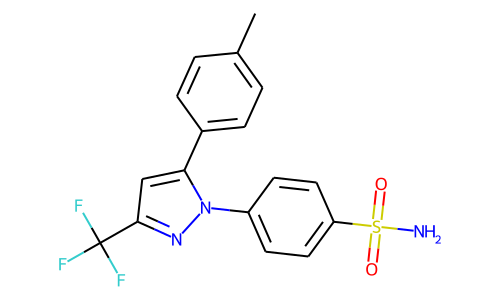

In [100]:
input_smiles = "O=S(=O)(c3ccc(n1nc(cc1c2ccc(cc2)C)C(F)(F)F)cc3)N"
#input_smiles = "C[C@@H]1CN(C2=NC(=CC=C2C(=O)NS(=O)(=O)C2=CN(C)N=C2C)N2C=CC(OCC(C)(C)C(F)(F)F)=N2)C(C)(C)C1"

mol1 = Chem.MolFromSmiles(input_smiles)
d2d = rdMolDraw2D.MolDraw2DSVG(500,300)
rdMolDraw2D.PrepareAndDrawMolecule(d2d, mol1)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

Visualize the fragment to be changed

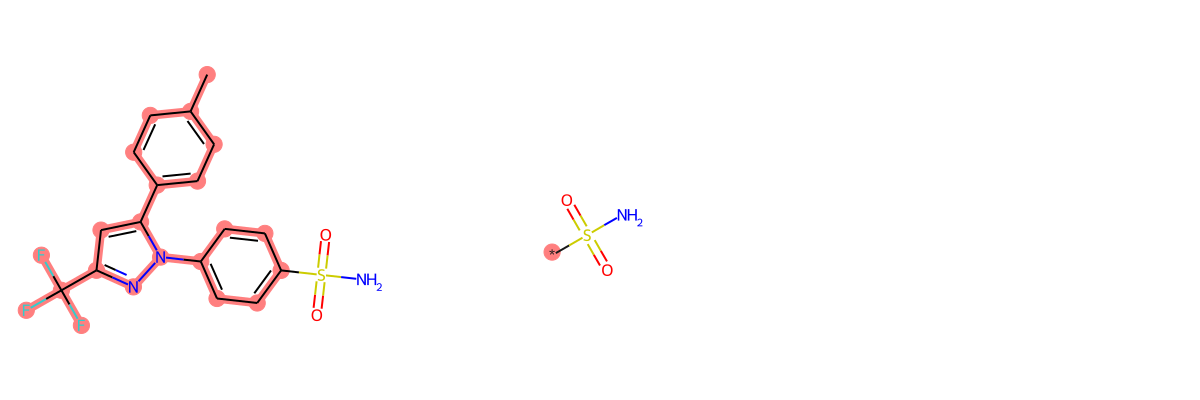

In [101]:
input_frag = "*S(=O)(=O)(N)"
#input_frag = "CC1=NN(C)C=C1[*]"

mol2 = Chem.MolFromSmiles(input_frag)
view_difference(mol1,mol2)

Generate suggestions

In [103]:
!mmpdb mmpCompoundGenerator --tsmiles "O=S(=O)(c3ccc(n1nc(cc1c2ccc(cc2)C)C(F)(F)F)cc3)N" --transformation_db "chemblDB3.sqlitdb" --replaceGroup "*S(=O)(=O)(N)" --tradius 3 --toutput mmpa_suggestions.csv --tmin-pairs 25

#!mmpdb mmpCompoundGenerator --tsmiles "C[C@@H]1CN(C2=NC(=CC=C2C(=O)NS(=O)(=O)C2=CN(C)N=C2C)N2C=CC(OCC(C)(C)C(F)(F)F)=N2)C(C)(C)C1" --transformation_db "chemblDB3.sqlitdb" --replaceGroup "CC1=NN(C)C=C1[*]" --tradius 3 --toutput mmpa_suggestions.csv --tmin-pairs 5

[15:49:08] WARNING: not removing hydrogen atom with dummy atom neighbors
DONE: output written to mmpa_suggestions.csv file

Dataframe of the results

In [104]:
df = pd.read_csv("mmpa_suggestions.csv", sep='\t')       
df.insert(0, 'ID', range(1, 1+len(df)))
df = df.drop(columns=['original_smi','constant_smi','original_frag','envsmi','ex_lhs_cpd_smi','ex_rhs_cpd_smi','ex_lhs_cpd_id','ex_rhs_cpd_id'])    # some columns are good algorithms check but otherwise unnecessary
#df2 = df.head(200)
df

,ID,transformed_smi,new_frag,rule_freq,heavies_diff
0,1,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccccc2)cc1,[*:1][H],1103,0
1,2,COc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc(C)cc2)cc1,[*:1]OC,607,2
2,3,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(Cl)cc2)cc1,[*:1]Cl,523,1
3,4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(C)(=O)=O)cc2...,[*:1]S(C)(=O)=O,497,4
4,5,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(F)cc2)cc1,[*:1]F,491,1
5,6,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(C)cc2)cc1,[*:1]C,408,1
6,7,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(C(=O)O)cc2)cc1,[*:1]C(=O)O,275,3
7,8,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc([N+](=O)[O-])c...,[*:1][N+](=O)[O-],265,3
8,9,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(O)cc2)cc1,[*:1]O,255,1
9,10,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(C(N)=O)cc2)cc1,[*:1]C(N)=O,215,3


Visualize the suggestions (use 'transformed_smi' or 'new_frag' for smiles)

In [105]:
grid = mols2grid.MolGrid(df, smiles_col="transformed_smi", size=(225, 200), name="something")
grid.display(subset=['ID',"rule_freq","img"], n_cols=4)

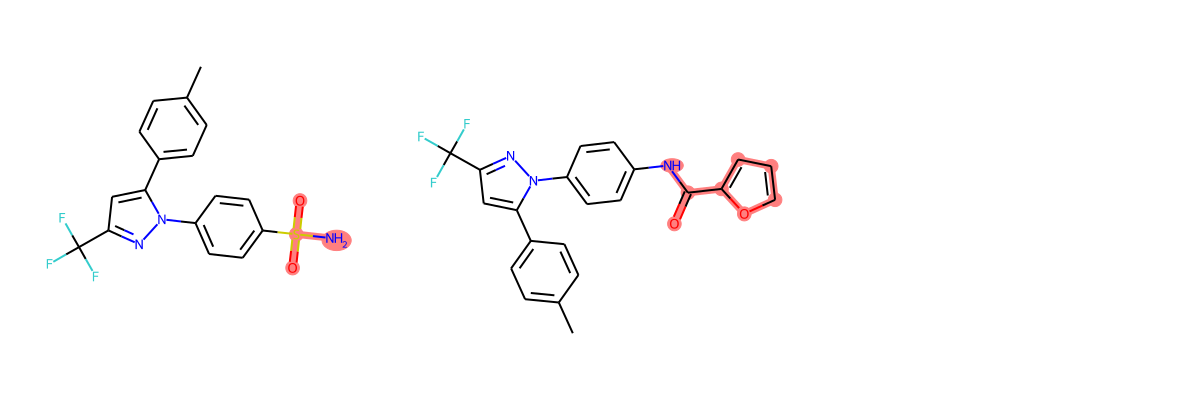

In [107]:
ID = 55    # the ID for the molecule of interest

df2 = df.loc[df['ID'] == ID]
df_smi = df2['transformed_smi']
np_smi = df_smi.to_numpy()
mol2 = Chem.MolFromSmiles(np_smi[0])

view_difference(mol1,mol2)